In [1]:
import numpy as np
import nengo
from nengo.solvers import LstsqL2, NoSolver
from nengo.utils.matplotlib import rasterplot
from nengo.dists import Uniform
import nengolib
from nengolib.signal import s

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='poster', style='whitegrid')
%matplotlib inline

from nengo_bioneurons import BahlNeuron

/home/pduggins/.virtualenvs/nengo_bioneuron/local/lib/python2.7/site-packages/nengo/builder/builder.py:234: UserWarning: Type '<class 'nengo.connection.Connection'>' already has a builder. Overwriting.
  % nengo_class)


In [6]:
def simulate_lowpass(
    d_supv_out,
    d_supv_bio,
    d_bio_out,
    d_bio_bio,
    target_data,
    t=9,
    n_neurons=10,
    n_syns=1,
    sec='tuft',
    taus={'network': 0.1,
          'readout': 0.1},
    regs={'pre_u-bio': 0.1,
          'pre_x-bio': 0.1,
          'pre_noise-bio': 0.1,
          'bio-bio': 1.0,
          'bio-out': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4},
    encoders=Uniform(-1e0,1e0),
    gain=Uniform(-1e2, 1e2),
    bias=Uniform(-5e-5, 5e-5),
    neuron_type=BahlNeuron(bias_method='weights'),
    noise_conn=False,
    sigma_noise=0.03,
    verbose=True):
    
    pre_kwargs = dict(
        n_neurons=100,
        dimensions=1,
        max_rates=Uniform(20, 40),
        seed=seeds['es'])
    
    bio_kwargs = dict(
        n_neurons=n_neurons,
        dimensions=1,
        encoders=encoders,
        gain=gain,
        bias=bias,
        neuron_type=neuron_type,
        seed=seeds['es'])
    
    conn_kwargs = dict(
        sec=sec,
        n_syn=n_syns,
        syn_type='ExpSyn',
        tau_list=[taus['network']],
        synapse=taus['network'],
        seed=seeds['cs'])
        
    def make_model(sign):
        with nengo.Network(seed=seeds['ns']) as model:
            u = nengo.Node(output = lambda t: sign*(t<=1))
            x = nengo.Node(output = lambda t: sign*target_data[int(t/0.001)-1])
            noise = nengo.Node(nengo.processes.WhiteNoise(
                dist=nengo.dists.Gaussian(0, sigma_noise), seed=seeds['ss']))
            pre_u = nengo.Ensemble(**pre_kwargs)
            pre_x = nengo.Ensemble(**pre_kwargs)
            pre_noise = nengo.Ensemble(**pre_kwargs)
            supv = nengo.Ensemble(**bio_kwargs)
            bio = nengo.Ensemble(**bio_kwargs)

            nengo.Connection(u, pre_u, synapse=None, seed=seeds['cs'])
            nengo.Connection(x, pre_x, synapse=None, seed=seeds['cs'])
            nengo.Connection(noise, pre_noise, synapse=None, seed=seeds['cs'])
            # feed u into supv and bio
            nengo.Connection(pre_u, supv,
                transform=taus['network'],
                solver=LstsqL2(reg=regs['pre_u-bio']),
                **conn_kwargs)
            nengo.Connection(pre_u, bio,
                transform=taus['network'],
                solver=LstsqL2(reg=regs['pre_u-bio']),
                **conn_kwargs)
            if noise_conn:
                nengo.Connection(pre_noise, bio,
                    solver=LstsqL2(reg=regs['pre_noise-bio']),
                    **conn_kwargs)                
            # feed x into supervisor
            nengo.Connection(pre_x, supv, solver=LstsqL2(reg=regs['pre_x-bio']), **conn_kwargs)
            # feed x from supv to bio
            nengo.Connection(supv, bio, solver=NoSolver(d_supv_bio), **conn_kwargs)      
            # feed x from bio to bio
            nengo.Connection(bio, bio, solver=NoSolver(d_bio_bio), **conn_kwargs)

            model.p_u = nengo.Probe(u, synapse=None)
            model.p_target = nengo.Probe(x, synapse=None)
            model.p_act_supv = nengo.Probe(supv.neurons, synapse=None)
            model.p_act_bio = nengo.Probe(bio.neurons, synapse=None)
            model.p_supv = nengo.Probe(supv, synapse=taus['readout'], solver=NoSolver(d_supv_out))
            model.p_bio = nengo.Probe(bio, synapse=taus['readout'], solver=NoSolver(d_bio_out))
            
        return model

    # simulate twice with sign = +1, -1
    model_p = make_model(+1.0)
    with nengo.Simulator(model_p, seed=seeds['ss']) as sim:
        sim.run(t)
    target_p = nengo.Lowpass(taus['readout']).filt(sim.data[model_p.p_target])
    spikes_supv_p = sim.data[model_p.p_act_supv]
    spikes_bio_p = sim.data[model_p.p_act_bio]
    act_supv_p = nengo.Lowpass(taus['readout']).filt(spikes_supv_p)
    act_bio_p = nengo.Lowpass(taus['readout']).filt(spikes_bio_p)
    xhat_supv_p = sim.data[model_p.p_supv]
    xhat_bio_p = sim.data[model_p.p_bio]
    del model_p
    
    model_n = make_model(-1.0)
    with nengo.Simulator(model_n, seed=seeds['ss']) as sim:
        sim.run(t)
    target_n = nengo.Lowpass(taus['readout']).filt(sim.data[model_n.p_target])
    spikes_supv_n = sim.data[model_n.p_act_supv]
    spikes_bio_n = sim.data[model_n.p_act_bio]
    act_supv_n = nengo.Lowpass(taus['readout']).filt(spikes_supv_n)
    act_bio_n = nengo.Lowpass(taus['readout']).filt(spikes_bio_n)   
    xhat_supv_n = sim.data[model_n.p_supv]
    xhat_bio_n = sim.data[model_n.p_bio]
    del model_n
    
    times = np.arange(0, 2*t, 0.001)
    target = np.vstack((target_p, target_n))
    spikes_supv = np.vstack((spikes_supv_p, spikes_supv_n))
    spikes_bio = np.vstack((spikes_bio_p, spikes_bio_n))
    act_supv = np.vstack((act_supv_p, act_supv_n))
    act_bio = np.vstack((act_bio_p, act_bio_n))
    xhat_supv = np.vstack((xhat_supv_p, xhat_supv_n))
    xhat_bio = np.vstack((xhat_bio_p, xhat_bio_n))
    
    nrmse_supv = nengolib.signal.nrmse(xhat_supv, target=target)
    nrmse_bio = nengolib.signal.nrmse(xhat_bio, target=target)

    if verbose:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))
        rasterplot(times, spikes_supv, ax=ax1)
        ax1.set(xlabel='time', ylabel='neuron')
        sns.distplot(np.ravel(act_supv), ax=ax2)
        ax2.set(xlim=((1, 50)), ylim=((0, 0.05)), xlabel='activity', ylabel='frequency')
        ax3.plot(times, target, label='target', linestyle='--')
        ax3.plot(times, xhat_supv, alpha=0.5, label='supv')
        ax3.set(xlabel='time', ylabel='$x$', title='nrmse=%.3f'%nrmse_supv)
        ax3.legend()
        fig.suptitle('supervisor')
        plt.tight_layout()
        
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))
        rasterplot(times, spikes_bio, ax=ax1)
        ax1.set(xlabel='time', ylabel='neuron')
        sns.distplot(np.ravel(act_bio), ax=ax2)
        ax2.set(xlim=((1, 50)), ylim=((0, 0.05)), xlabel='activity', ylabel='frequency')
        ax3.plot(times, target, label='target', linestyle='--')
        ax3.plot(times, xhat_bio, alpha=0.5, label='bio')
        ax3.set(xlabel='time', ylabel='$x$', title='nrmse=%.3f'%nrmse_bio)
        ax3.legend()
        fig.suptitle('bio')
        plt.tight_layout()
        
        plt.show()

    d_supv_out_new = LstsqL2(reg=regs['bio-out'])(act_supv, target)[0]
    d_supv_bio_new = LstsqL2(reg=regs['bio-bio'])(act_supv, target)[0]
    d_bio_out_new = LstsqL2(reg=regs['bio-out'])(act_bio, target)[0]
    d_bio_bio_new = LstsqL2(reg=regs['bio-bio'])(act_bio, target)[0]
    
    return d_supv_out_new, d_supv_bio_new, d_bio_out_new, d_bio_bio_new

Training d_supv...
Building finished in 0:00:02.                                                   
Simulating finished in 0:38:56.                                                 
Building finished in 0:00:03.                                                   
Simulating finished in 0:38:19.                                                 


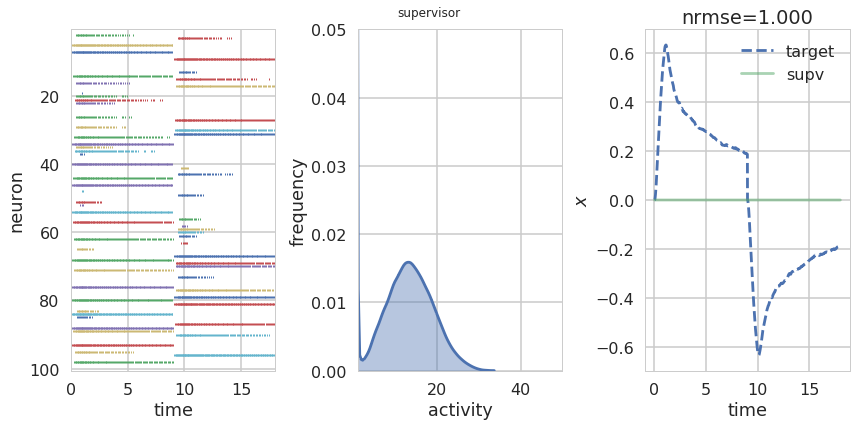

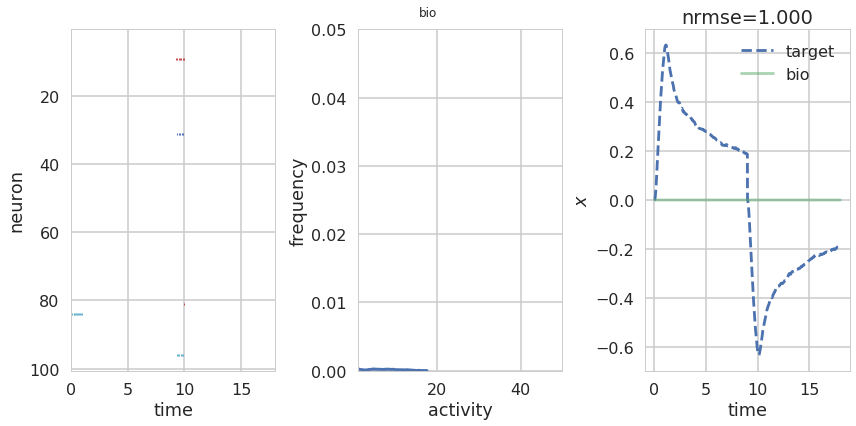

Training d_bio...
Building finished in 0:00:03.                                                   
Simulating finished in 0:37:42.                                                 
Building finished in 0:00:03.                                                   
Simulating finished in 0:39:46.                                                 


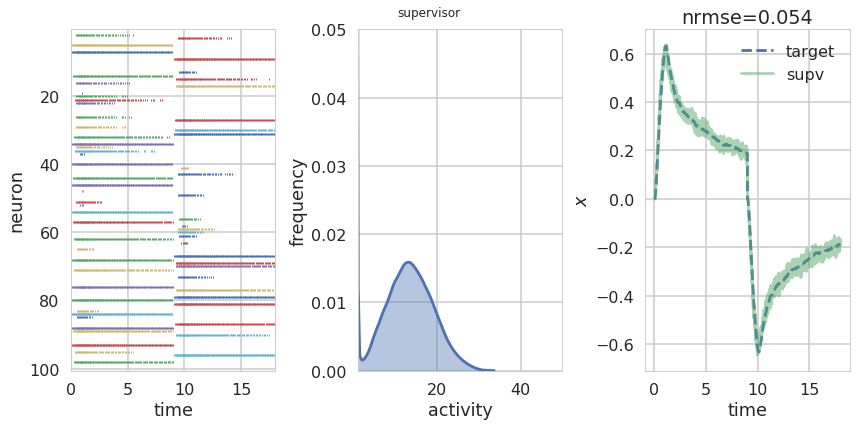

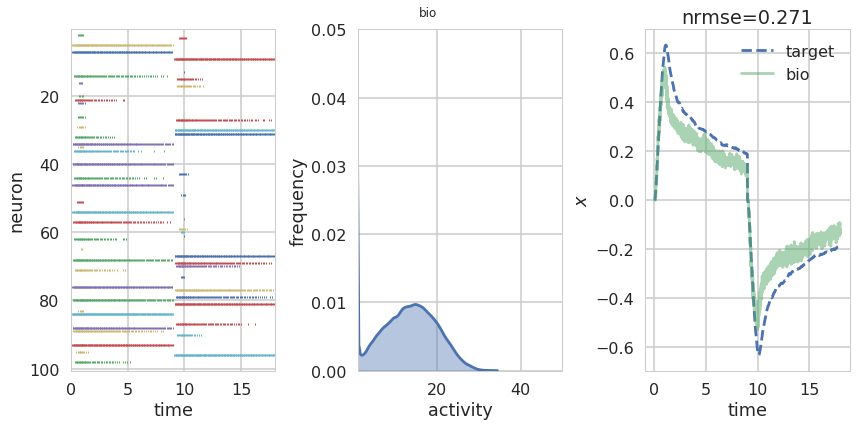

Testing with full recurrence...
Building finished in 0:00:03.                                                   
Simulating finished in 0:39:09.                                                 
Building finished in 0:00:02.                                                   
Simulating finished in 0:38:28.                                                 


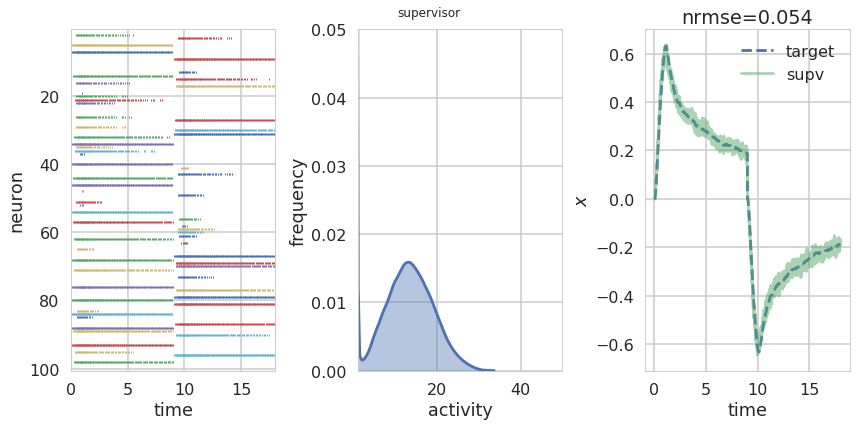

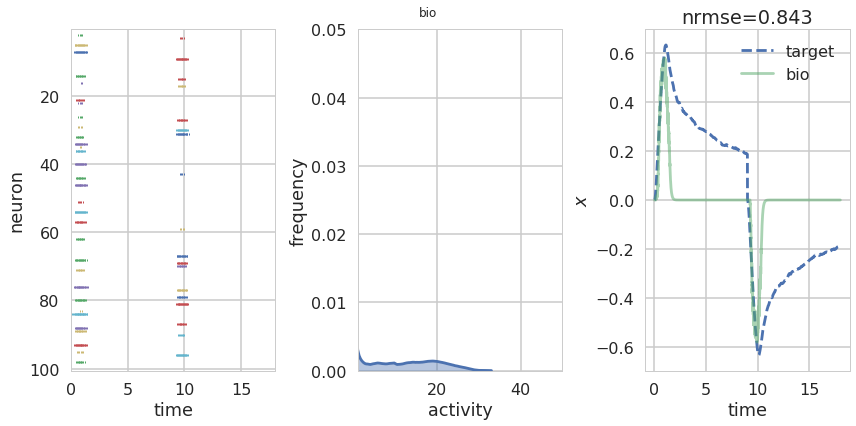

In [3]:
n_neurons = 100
t = 9
target_file = '/home/pduggins/drugs_and_working_memory/drugs_and_working_memory/' + \
    'data/sDRT_LIF/control_functional.npz'
target_data = np.average(np.load(target_file)['wm_data'], axis=0)

d_supv_out_init = np.zeros((n_neurons, 1))
d_supv_bio_init = np.zeros((n_neurons, 1))
d_bio_out_init = np.zeros((n_neurons, 1))
d_bio_bio_init = np.zeros((n_neurons, 1))

print "Training d_supv..."
d_supv_out, d_supv_bio, _, _ = simulate_lowpass(
    d_supv_out_init,
    d_supv_bio_init,
    d_bio_out_init,
    d_bio_bio_init,
    target_data=target_data,
    n_neurons=n_neurons,
    t=t,
    verbose=True)

print "Training d_bio..."
_, _, d_bio_out, d_bio_bio = simulate_lowpass(
    d_supv_out,
    d_supv_bio,
    d_supv_out,
    d_bio_bio_init,
    target_data=target_data,
    n_neurons=n_neurons,
    t=t,
    verbose=True)

print "Testing with full recurrence..."
_, _, _, _ = simulate_lowpass(
    d_supv_out,
    d_supv_bio_init,
    d_bio_out,
    d_bio_bio,
    target_data=target_data,
    n_neurons=n_neurons,
    t=t,
    verbose=True)

Training d_supv...
Building finished in 0:00:02.                                                   
Simulating finished in 0:41:33.                                                 
Building finished in 0:00:03.                                                   
Simulating finished in 0:39:07.                                                 


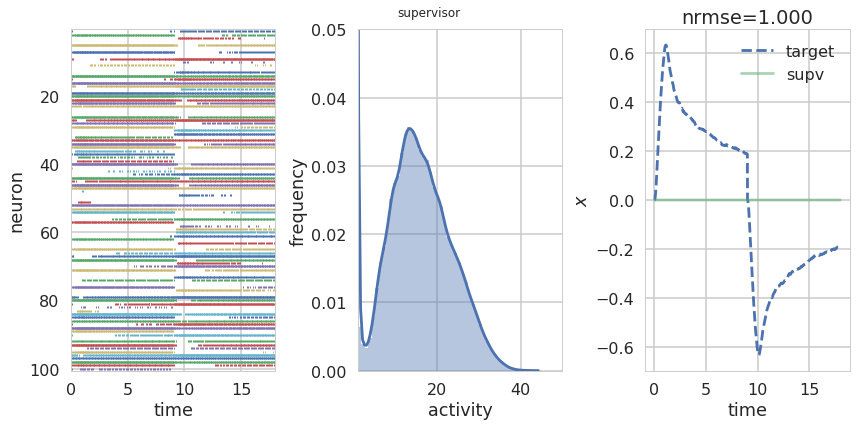

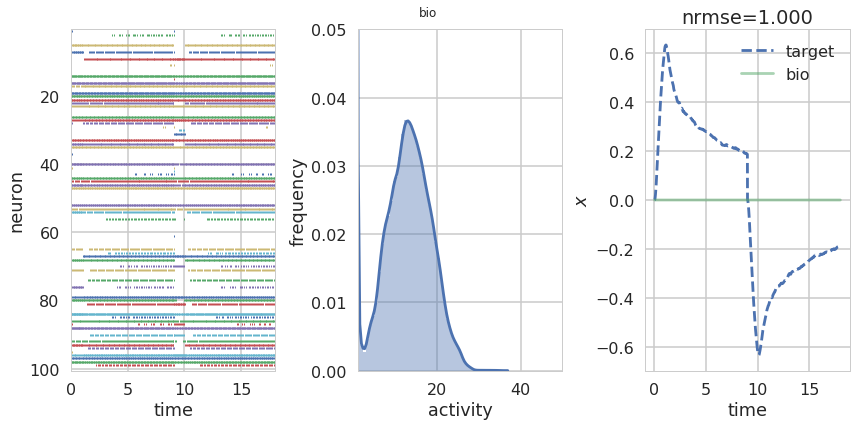

Training d_bio...
Building finished in 0:00:02.                                                   
Simulating finished in 0:39:19.                                                 
Building finished in 0:00:02.                                                   
Simulating finished in 0:39:15.                                                 


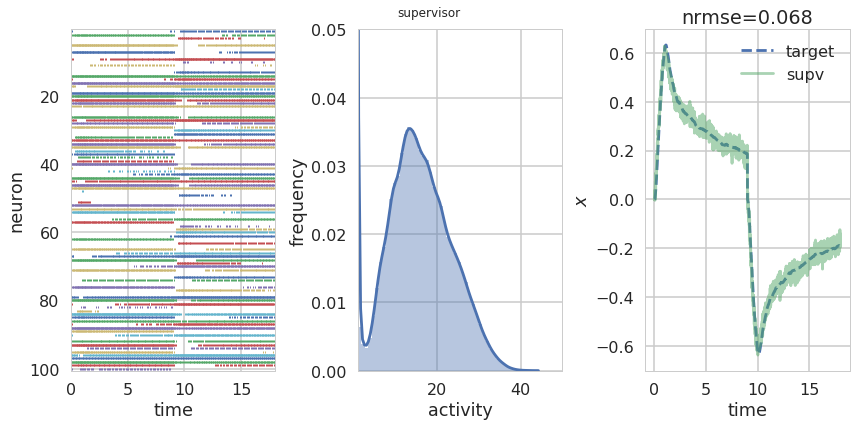

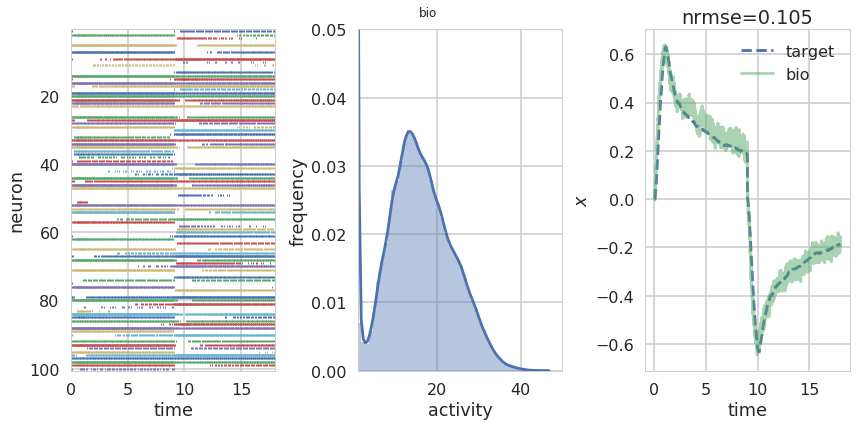

Testing with full recurrence...
Building finished in 0:00:02.                                                   
Simulating finished in 0:39:56.                                                 
Building finished in 0:00:02.                                                   
Simulating finished in 0:40:09.                                                 


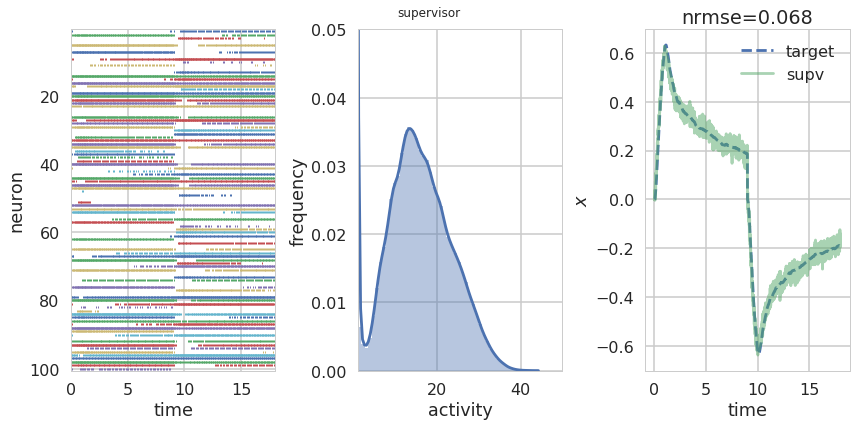

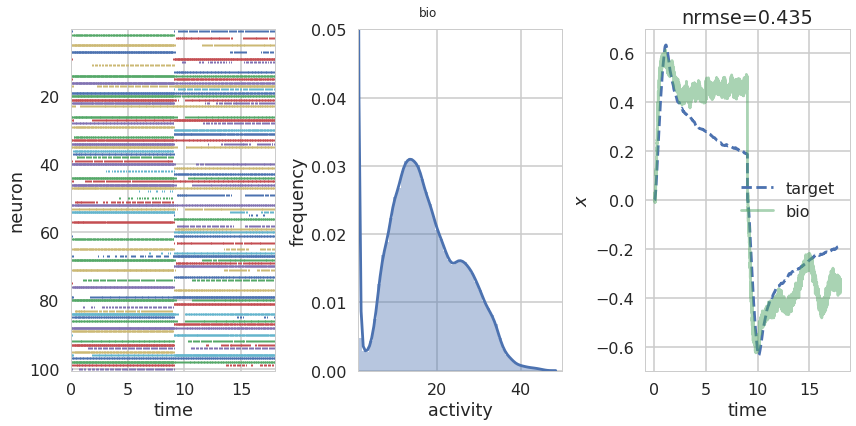

In [3]:
n_neurons = 100
t = 9
target_file = '/home/pduggins/drugs_and_working_memory/drugs_and_working_memory/' + \
    'data/sDRT_LIF/control_functional.npz'
target_data = np.average(np.load(target_file)['wm_data'], axis=0)
regs={'pre_u-bio': 0.1,
      'pre_x-bio': 0.1,
      'bio-bio': 0.1,
      'bio-out': 0.1}
bias = Uniform(-3e-4, 3e-4)

d_supv_out_init = np.zeros((n_neurons, 1))
d_supv_bio_init = np.zeros((n_neurons, 1))
d_bio_out_init = np.zeros((n_neurons, 1))
d_bio_bio_init = np.zeros((n_neurons, 1))

print "Training d_supv..."
d_supv_out, d_supv_bio, _, _ = simulate_lowpass(
    d_supv_out_init,
    d_supv_bio_init,
    d_bio_out_init,
    d_bio_bio_init,
    target_data=target_data,
    n_neurons=n_neurons,
    regs=regs,
    bias=bias,
    t=t,
    verbose=True)

print "Training d_bio..."
_, _, d_bio_out, d_bio_bio = simulate_lowpass(
    d_supv_out,
    d_supv_bio,
    d_supv_out,
    d_bio_bio_init,
    target_data=target_data,
    n_neurons=n_neurons,
    regs=regs,
    bias=bias,
    t=t,
    verbose=True)

print "Testing with full recurrence..."
_, _, _, _ = simulate_lowpass(
    d_supv_out,
    d_supv_bio_init,
    d_bio_out,
    d_bio_bio,
    target_data=target_data,
    n_neurons=n_neurons,
    regs=regs,
    bias=bias,
    t=t,
    verbose=True)

Training d_supv...
Building finished in 0:00:02.                                                   
Simulating finished in 0:41:13.                                                 
Building finished in 0:00:02.                                                   
Simulating finished in 0:33:34.                                                 


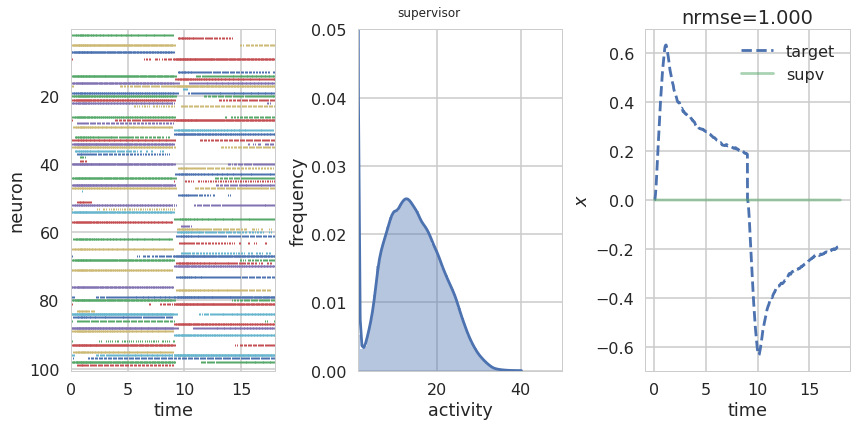

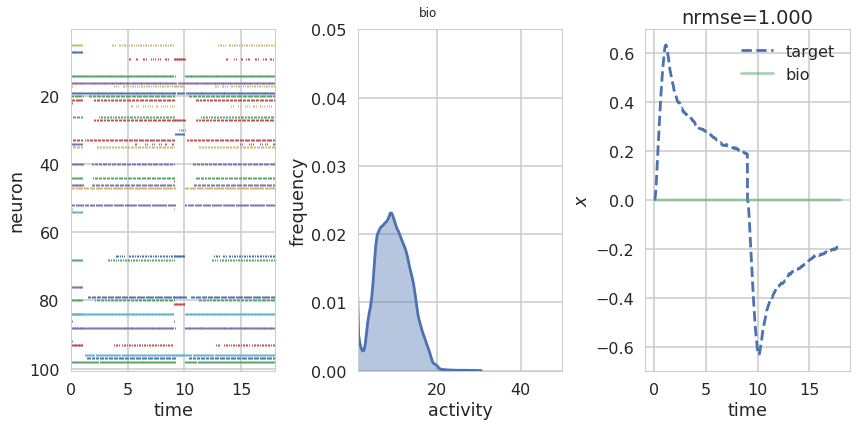

Training d_bio...
Building finished in 0:00:02.                                                   
Simulating finished in 0:36:00.                                                 
Building finished in 0:00:02.                                                   
Simulating finished in 0:34:18.                                                 


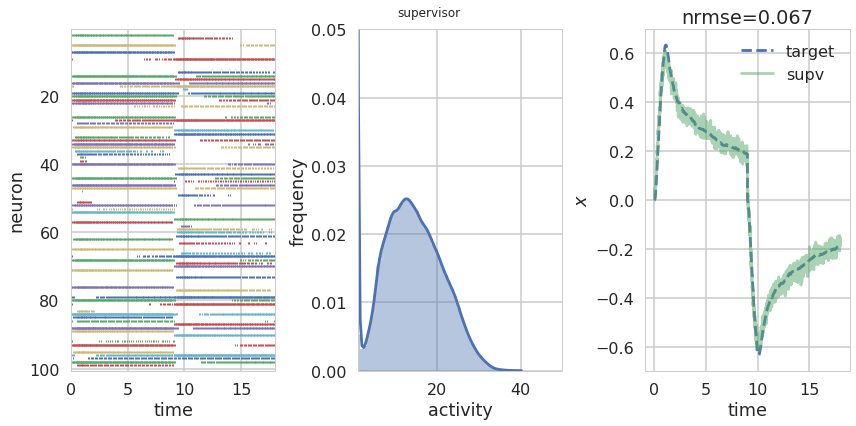

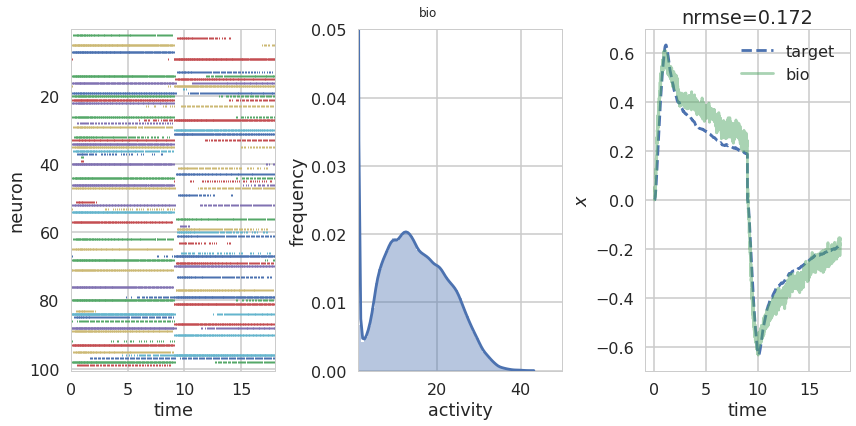

Testing with full recurrence...
Building finished in 0:00:02.                                                   
Simulating finished in 0:38:36.                                                 
Building finished in 0:00:02.                                                   
Simulating finished in 0:37:32.                                                 


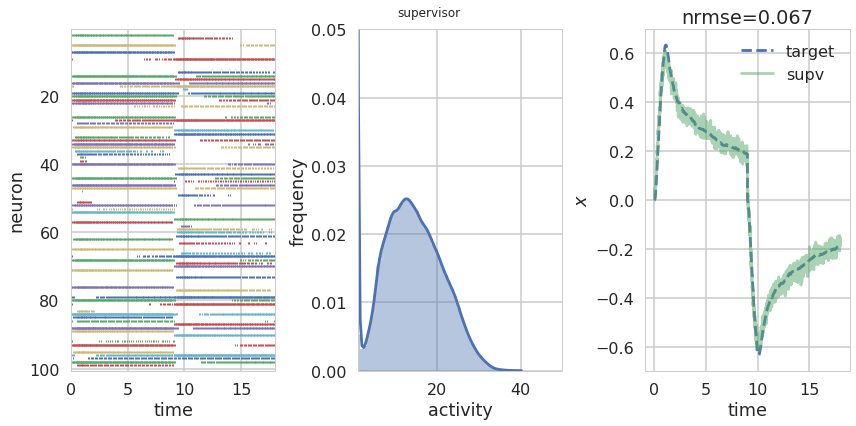

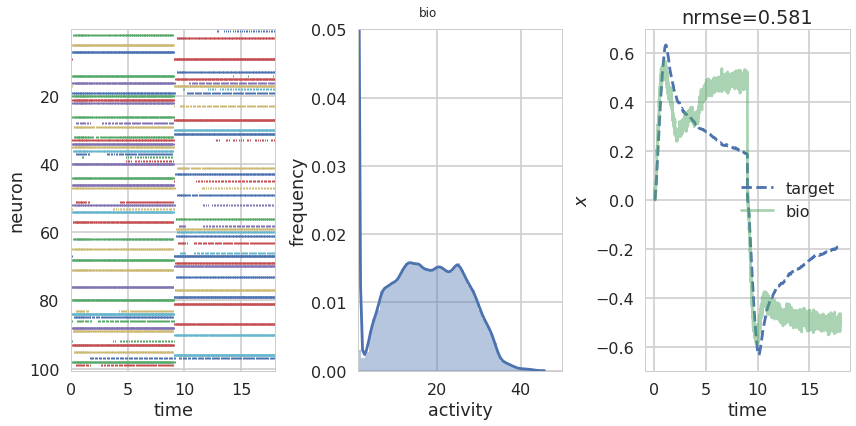

In [4]:
n_neurons = 100
t = 9
target_file = '/home/pduggins/drugs_and_working_memory/drugs_and_working_memory/' + \
    'data/sDRT_LIF/control_functional.npz'
target_data = np.average(np.load(target_file)['wm_data'], axis=0)
regs={'pre_u-bio': 0.1,
      'pre_x-bio': 0.1,
      'bio-bio': 0.1,
      'bio-out': 0.1}
bias = Uniform(-2e-4, 2e-4)

d_supv_out_init = np.zeros((n_neurons, 1))
d_supv_bio_init = np.zeros((n_neurons, 1))
d_bio_out_init = np.zeros((n_neurons, 1))
d_bio_bio_init = np.zeros((n_neurons, 1))

print "Training d_supv..."
d_supv_out, d_supv_bio, _, _ = simulate_lowpass(
    d_supv_out_init,
    d_supv_bio_init,
    d_bio_out_init,
    d_bio_bio_init,
    target_data=target_data,
    n_neurons=n_neurons,
    regs=regs,
    bias=bias,
    t=t,
    verbose=True)

print "Training d_bio..."
_, _, d_bio_out, d_bio_bio = simulate_lowpass(
    d_supv_out,
    d_supv_bio,
    d_supv_out,
    d_bio_bio_init,
    target_data=target_data,
    n_neurons=n_neurons,
    regs=regs,
    bias=bias,
    t=t,
    verbose=True)

print "Testing with full recurrence..."
_, _, _, _ = simulate_lowpass(
    d_supv_out,
    d_supv_bio_init,
    d_bio_out,
    d_bio_bio,
    target_data=target_data,
    n_neurons=n_neurons,
    regs=regs,
    bias=bias,
    t=t,
    verbose=True)

Training d_supv...
Building finished in 0:00:02.                                                   
Simulating finished in 0:37:33.                                                 
Building finished in 0:00:02.                                                   
Simulating finished in 0:36:45.                                                 


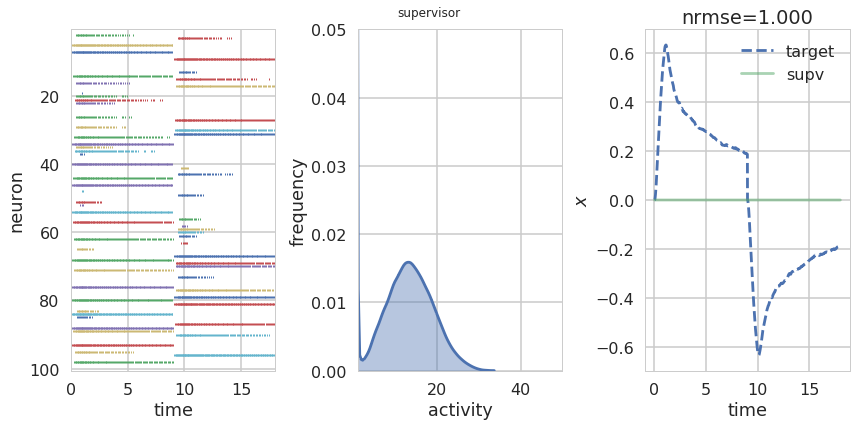

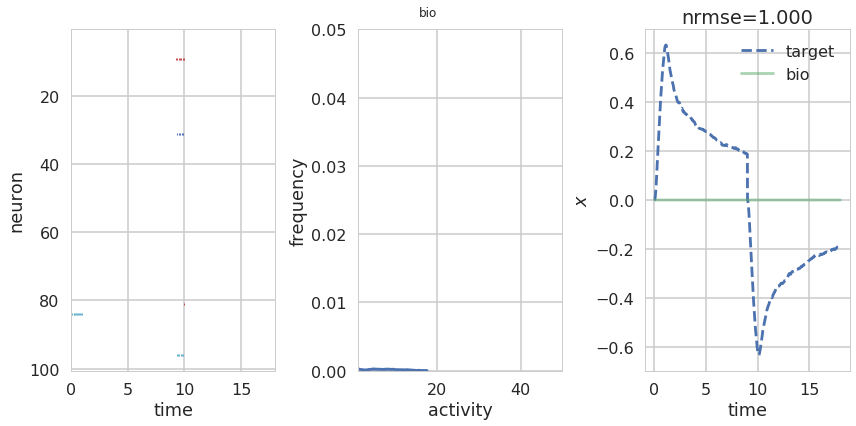

Training d_bio...
Building finished in 0:00:02.                                                   
Simulating finished in 0:38:39.                                                 
Building finished in 0:00:02.                                                   
Simulating finished in 0:38:38.                                                 


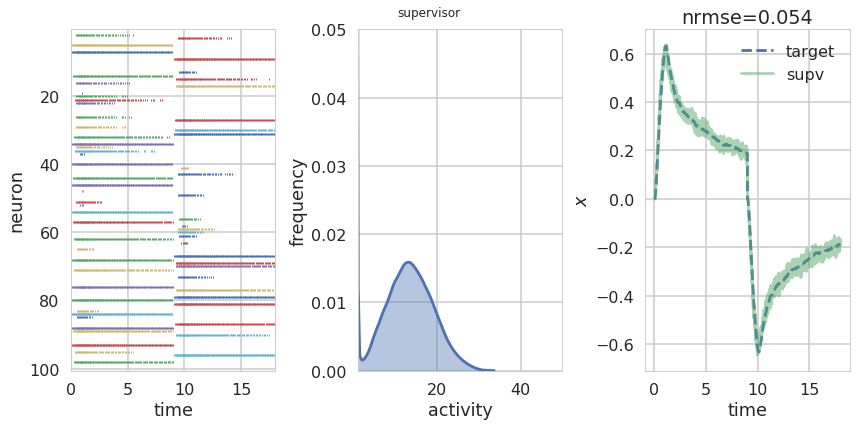

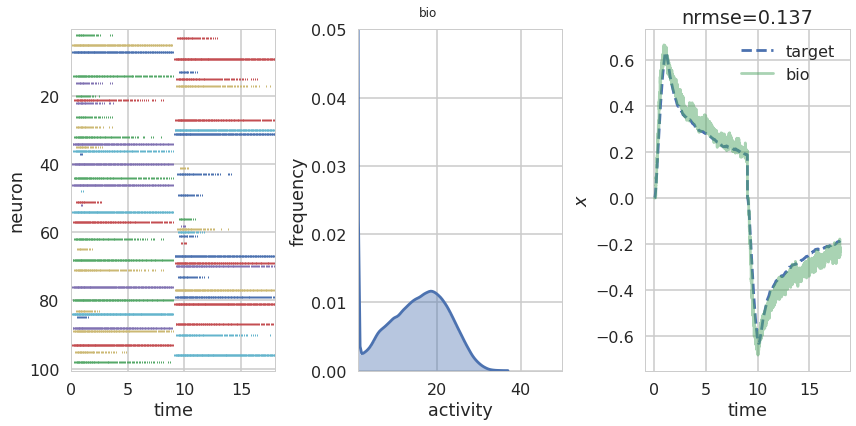

Testing with full recurrence...
Building finished in 0:00:02.                                                   
Simulating finished in 0:40:15.                                                 
Building finished in 0:00:02.                                                   
Simulating finished in 0:38:17.                                                 


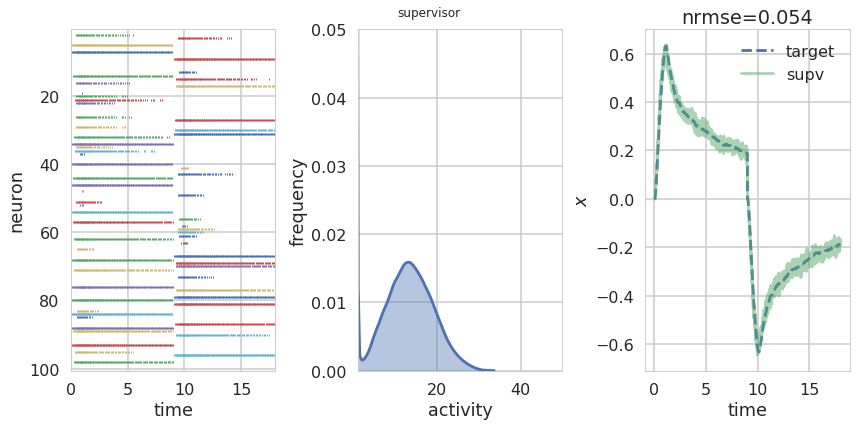

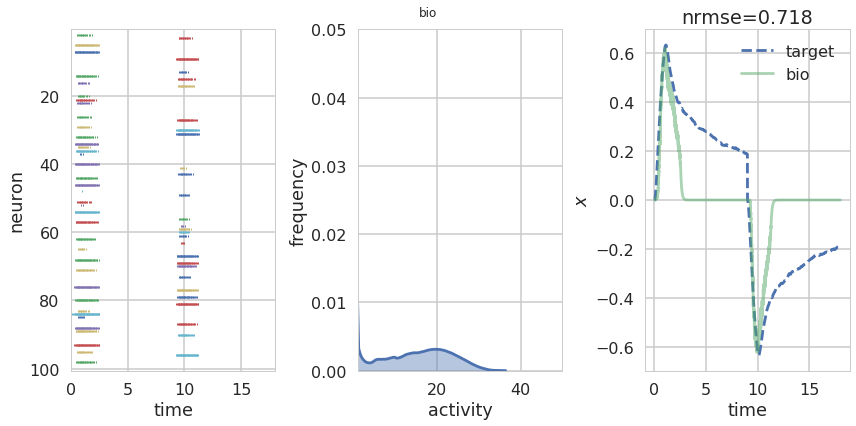

In [5]:
n_neurons = 100
t = 9
target_file = '/home/pduggins/drugs_and_working_memory/drugs_and_working_memory/' + \
    'data/sDRT_LIF/control_functional.npz'
target_data = np.average(np.load(target_file)['wm_data'], axis=0)
regs={'pre_u-bio': 0.1,
      'pre_x-bio': 0.1,
      'bio-bio': 0.1,
      'bio-out': 0.1}
bias = Uniform(-5e-5, 5e-5)

d_supv_out_init = np.zeros((n_neurons, 1))
d_supv_bio_init = np.zeros((n_neurons, 1))
d_bio_out_init = np.zeros((n_neurons, 1))
d_bio_bio_init = np.zeros((n_neurons, 1))

print "Training d_supv..."
d_supv_out, d_supv_bio, _, _ = simulate_lowpass(
    d_supv_out_init,
    d_supv_bio_init,
    d_bio_out_init,
    d_bio_bio_init,
    target_data=target_data,
    n_neurons=n_neurons,
    regs=regs,
    bias=bias,
    t=t,
    verbose=True)

print "Training d_bio..."
_, _, d_bio_out, d_bio_bio = simulate_lowpass(
    d_supv_out,
    d_supv_bio,
    d_supv_out,
    d_bio_bio_init,
    target_data=target_data,
    n_neurons=n_neurons,
    regs=regs,
    bias=bias,
    t=t,
    verbose=True)

print "Testing with full recurrence..."
_, _, _, _ = simulate_lowpass(
    d_supv_out,
    d_supv_bio_init,
    d_bio_out,
    d_bio_bio,
    target_data=target_data,
    n_neurons=n_neurons,
    regs=regs,
    bias=bias,
    t=t,
    verbose=True)

Training d_supv...
Building finished in 0:00:03.                                                   
Simulating finished in 0:41:33.                                                 
Building finished in 0:00:02.                                                   
Simulating finished in 0:38:38.                                                 


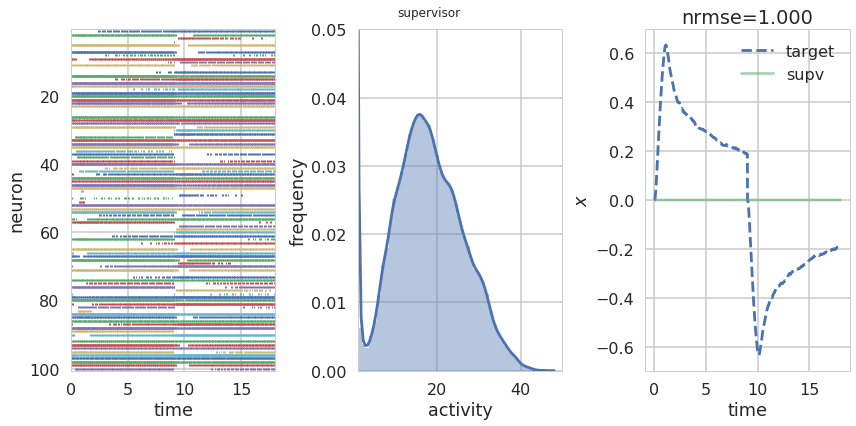

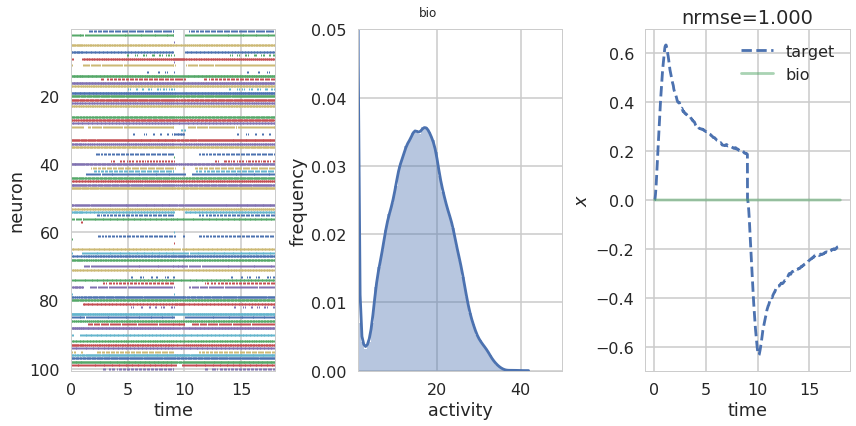

Training d_bio...
Building finished in 0:00:02.                                                   
Simulating finished in 0:37:31.                                                 
Building finished in 0:00:02.                                                   
Simulating finished in 0:39:17.                                                 


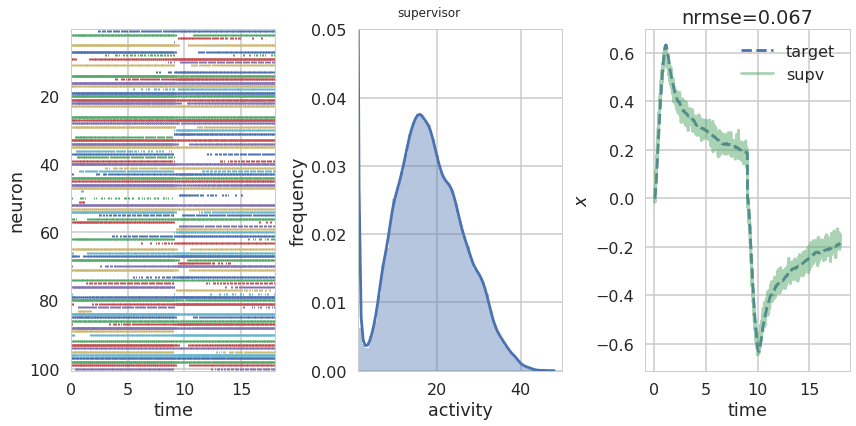

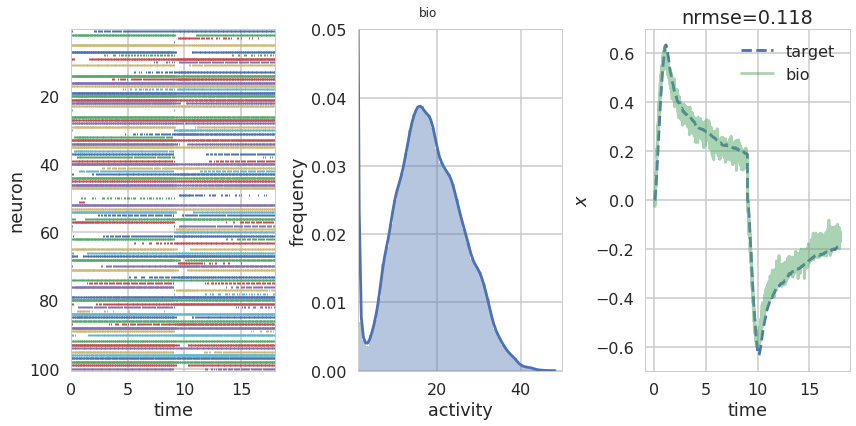

Testing with full recurrence...
Building finished in 0:00:02.                                                   
Simulating finished in 0:40:47.                                                 
Building finished in 0:00:02.                                                   
Simulating finished in 0:42:01.                                                 


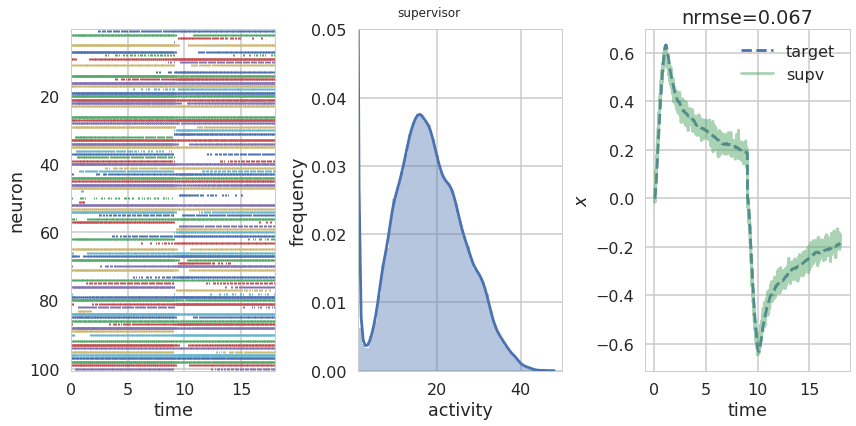

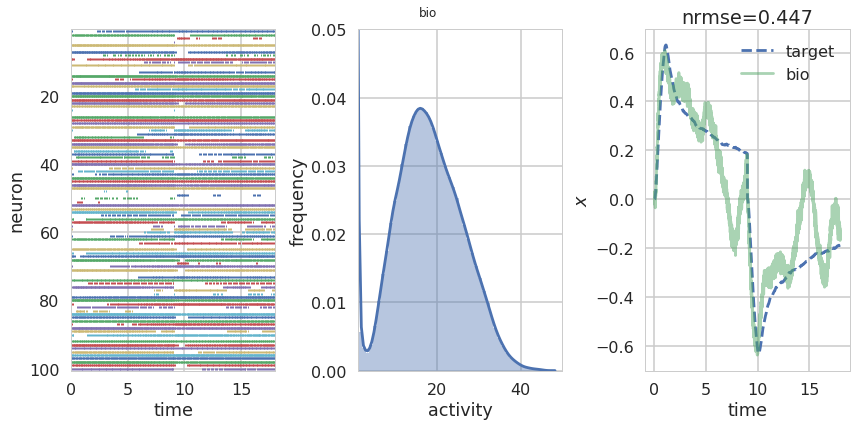

In [3]:
n_neurons = 100
t = 9
target_file = '/home/pduggins/drugs_and_working_memory/drugs_and_working_memory/' + \
    'data/sDRT_LIF/control_functional.npz'
target_data = np.average(np.load(target_file)['wm_data'], axis=0)
regs={'pre_u-bio': 0.1,
      'pre_x-bio': 0.1,
      'bio-bio': 0.1,
      'bio-out': 0.1}
bias = Uniform(-4e-4, 4e-4)

d_supv_out_init = np.zeros((n_neurons, 1))
d_supv_bio_init = np.zeros((n_neurons, 1))
d_bio_out_init = np.zeros((n_neurons, 1))
d_bio_bio_init = np.zeros((n_neurons, 1))

print "Training d_supv..."
d_supv_out, d_supv_bio, _, _ = simulate_lowpass(
    d_supv_out_init,
    d_supv_bio_init,
    d_bio_out_init,
    d_bio_bio_init,
    target_data=target_data,
    n_neurons=n_neurons,
    regs=regs,
    bias=bias,
    t=t,
    verbose=True)

print "Training d_bio..."
_, _, d_bio_out, d_bio_bio = simulate_lowpass(
    d_supv_out,
    d_supv_bio,
    d_supv_out,
    d_bio_bio_init,
    target_data=target_data,
    n_neurons=n_neurons,
    regs=regs,
    bias=bias,
    t=t,
    verbose=True)

print "Testing with full recurrence..."
_, _, _, _ = simulate_lowpass(
    d_supv_out,
    d_supv_bio_init,
    d_bio_out,
    d_bio_bio,
    target_data=target_data,
    n_neurons=n_neurons,
    regs=regs,
    bias=bias,
    t=t,
    verbose=True)

Training d_supv...
Building finished in 0:00:03.                                                   
Simulating finished in 0:47:56.                                                 
Building finished in 0:00:03.                                                   
Simulating finished in 0:54:10.                                                 


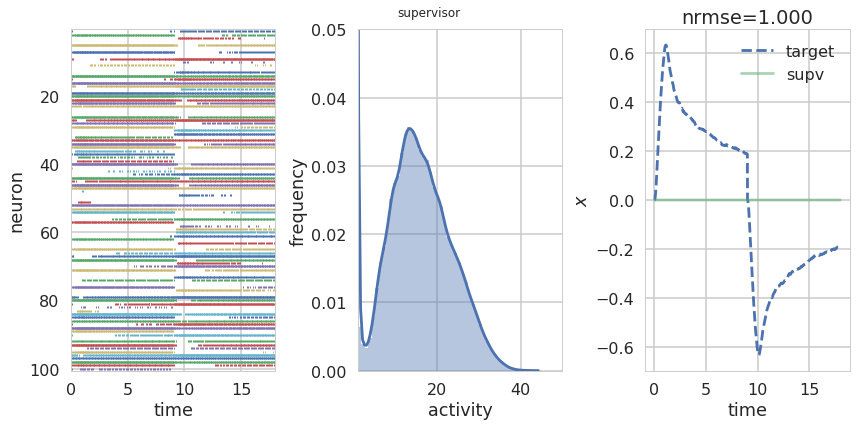

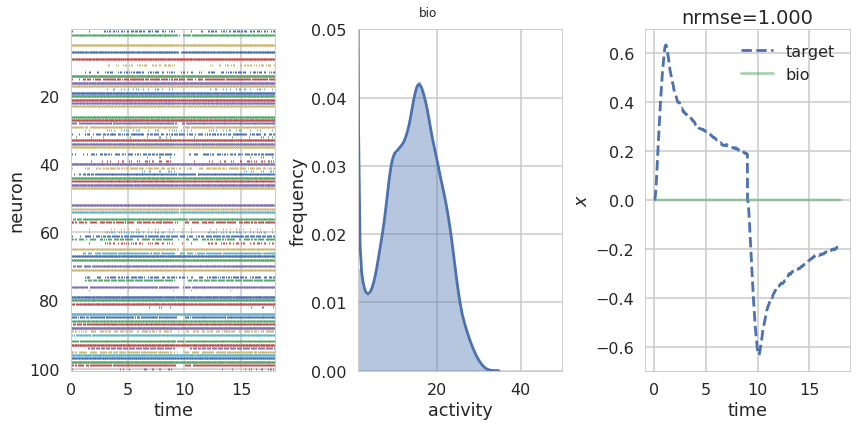

Training d_bio...
Building finished in 0:00:02.                                                   
Simulating finished in 1:01:02.                                                 
Building finished in 0:00:03.                                                   
Simulating finished in 0:48:27.                                                 


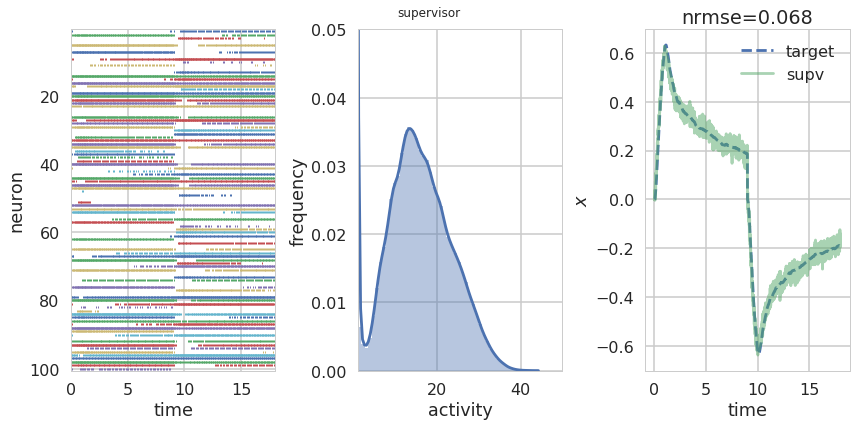

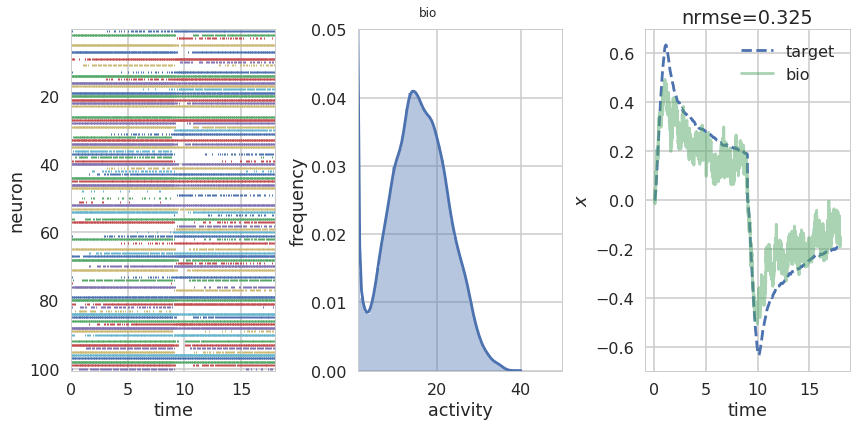

Testing with full recurrence...
Building finished in 0:00:02.                                                   
Simulating finished in 0:47:29.                                                 
Building finished in 0:00:03.                                                   
Simulating finished in 0:43:03.                                                 


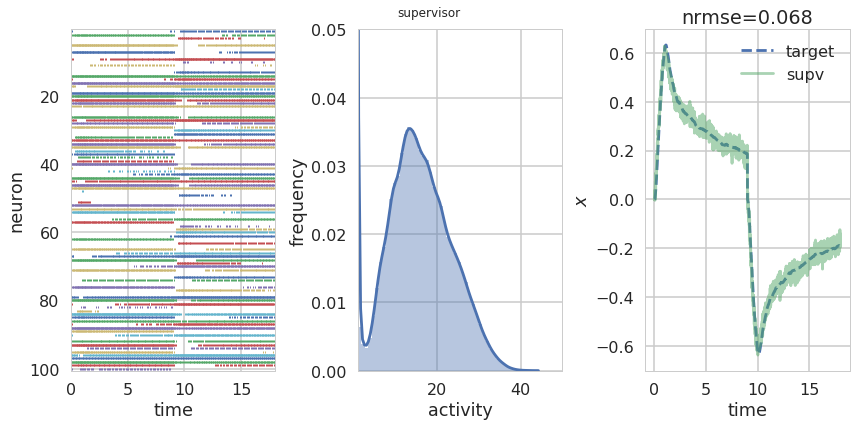

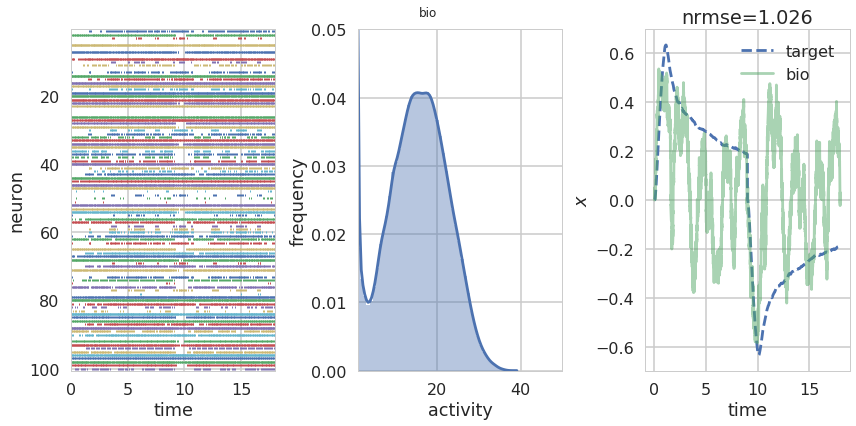

In [8]:
n_neurons = 100
t = 9
target_file = '/home/pduggins/drugs_and_working_memory/drugs_and_working_memory/' + \
    'data/sDRT_LIF/control_functional.npz'
target_data = np.average(np.load(target_file)['wm_data'], axis=0)
regs={'pre_u-bio': 0.1,
      'pre_x-bio': 0.1,
      'pre_noise-bio': 0.1,
      'bio-bio': 0.1,
      'bio-out': 0.1}
bias = Uniform(-3e-4, 3e-4)
sigma_noise = 0.03

d_supv_out_init = np.zeros((n_neurons, 1))
d_supv_bio_init = np.zeros((n_neurons, 1))
d_bio_out_init = np.zeros((n_neurons, 1))
d_bio_bio_init = np.zeros((n_neurons, 1))

print "Training d_supv..."
d_supv_out, d_supv_bio, _, _ = simulate_lowpass(
    d_supv_out_init,
    d_supv_bio_init,
    d_bio_out_init,
    d_bio_bio_init,
    target_data=target_data,
    n_neurons=n_neurons,
    regs=regs,
    bias=bias,
    noise_conn=True,
    sigma_noise=sigma_noise,
    t=t,
    verbose=True)

print "Training d_bio..."
_, _, d_bio_out, d_bio_bio = simulate_lowpass(
    d_supv_out,
    d_supv_bio,
    d_supv_out,
    d_bio_bio_init,
    target_data=target_data,
    n_neurons=n_neurons,
    regs=regs,
    bias=bias,
    noise_conn=True,
    sigma_noise=sigma_noise,
    t=t,
    verbose=True)

print "Testing with full recurrence..."
_, _, _, _ = simulate_lowpass(
    d_supv_out,
    d_supv_bio_init,
    d_bio_out,
    d_bio_bio,
    target_data=target_data,
    n_neurons=n_neurons,
    regs=regs,
    bias=bias,
    noise_conn=True,
    sigma_noise=sigma_noise,
    t=t,
    verbose=True)